<a href="https://colab.research.google.com/github/Anagefilho/UFU_Mestrado/blob/main/%5DGrupo04_ProjetoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  <font style="color:black">**Classificação de imagens de frutas usando CNN**</font>



## **Aplicação**

### Construção e treinamento de CNN para a classificação das imagens

In [ ]:
# baixar e descompactar as imagens dataset FruitGB, as quais contém imagens de bananas, maçãs, romã, limão, laranha e goiaba.
# Será criado a pasta Frutas no ambiente do colab (pasta de arquivos).

!wget -O Frutas.zip.zip https://www.dropbox.com/s/u6yctorg6fx8a7w/Frutas.zip?dl=0;

!unzip Frutas.zip;

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: Frutas/Treino/LimaoFresco/IMG_20190902_102523.jpg  
  inflating: Frutas/Treino/LimaoFresco/IMG_20190902_102523_1.jpg  
  inflating: Frutas/Treino/LimaoFresco/IMG_20190902_102525.jpg  
  inflating: Frutas/Treino/LimaoFresco/IMG_20190902_102525_1.jpg  
  inflating: Frutas/Treino/LimaoFresco/IMG_20190902_102526.jpg  
  inflating: Frutas/Treino/LimaoFresco/IMG_20190902_102527.jpg  
  inflating: Frutas/Treino/LimaoFresco/IMG_20190902_102533.jpg  
  inflating: Frutas/Treino/LimaoFresco/IMG_20190902_102535.jpg  
  inflating: Frutas/Treino/LimaoFresco/IMG_20190902_102535_1.jpg  
  inflating: Frutas/Treino/LimaoFresco/IMG_20190902_102536.jpg  
  inflating: Frutas/Treino/LimaoFresco/IMG_20190902_102537.jpg  
  inflating: Frutas/Treino/LimaoFresco/IMG_20190902_102537_1.jpg  
  inflating: Frutas/Treino/LimaoFresco/IMG_20190902_102540.jpg  
  inflating: Frutas/Treino/LimaoFresco/IMG_20190902_102540_1.jpg  
  inflating: Frutas/T

In [ ]:
# Importanto os pacotes necessários
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [ ]:
# Aumento e normalização de dados para treinamento
# Apenas normalização para validação
data_transforms = {
    # dados de treinamento
    'Treino': transforms.Compose([
        transforms.Resize((224,224)), # Pré-processamento para formatar as imagens em tamanho (224x224)
        transforms.RandomHorizontalFlip(), # Rotaciona a imagem de baixo para cima 
        transforms.ToTensor(), # Transforma no tipo de dado do pytorch
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalização contém a média e o desvio padrão para cada um dos canais RGB
    ]),
    
    # Podemos fazer cortes diferentes, mas a imagem final tem que ser 224x224
    # dados de validação
    'Teste': transforms.Compose([
        transforms.Resize((224,224)), # Pré-processamento para formatar as imagens em tamanho (256x256)
        transforms.ToTensor(),  # Transforma no tipo de dado do pytorch
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalização contém a média e o desvio padrão para cada um dos canais RGB
    ]),
}

In [ ]:
# Criando os datasets e dataloaders

# Aqui usamos a função ImageFolder para criar um dataset direto das pastas organizadas treino e teste.
# O pytorch entende automaticamente os nomes das pastas bom (bananas) e ruim (bananas) como as classes.

data_dir = 'Frutas'

# x está iterando nas pastas train e val para construir o dataset
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['Treino', 'Teste']}

# separando de 8 em 8 imagens para serem apresentadas a CNN de forma aleatória por causa do shuffle=True
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=0)
              for x in ['Treino', 'Teste']}

# Obter a quantidade de imagens de treinamento e validação
dataset_sizes = {x: len(image_datasets[x]) for x in ['Treino', 'Teste']}

# Obter o nome das classes de treinamento
class_names = image_datasets['Treino'].classes

# Utiliza GPU ou CPU, verificar no colab (Ambiente de execução -> Alterar o tipo de ambiente de execução)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f'Dataset sizes: {dataset_sizes}')
print(f'class names: {class_names}')
print(f'cuda: {device}')

Dataset sizes: {'Treino': 9898, 'Teste': 3950}
class names: ['BananaFresca', 'BananaPodre', 'GoiabaFresca', 'GoiabaPodre', 'LaranjaFresca', 'LaranjaPodre', 'LimaoFresco', 'LimaoPodre', 'MacaFresca', 'MacaPodre', 'RomaFresca', 'RomaPodre']
cuda: cuda:0


In [ ]:
# Funções auxiliares para a classificação das imagens usando CNN

# Função auxiliar para impimir um batch de imagens
def imshow(inp, title=None):
    # Reorganizar o dado para o formato adequado do matplotlib
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) # limita os dados da imagem entre [0,1]
    # plota a imagem
    plt.figure(dpi=250)
    plt.imshow(inp)    
    if title is not None:
        plt.title(title, fontsize=5.6)
    plt.pause(0.001)  # pause a bit so that plots are updated

 #Apresenta a dimensão de saída da imagem após a convolução (qual o tamanho do feature map?)
def out_conv2d(dim_input, kernel_size, padding=0, dilation=1, stride=1):
    dim_output = ((dim_input + 2 * padding - dilation * (kernel_size-1) - 1)/stride) + 1
    return dim_output

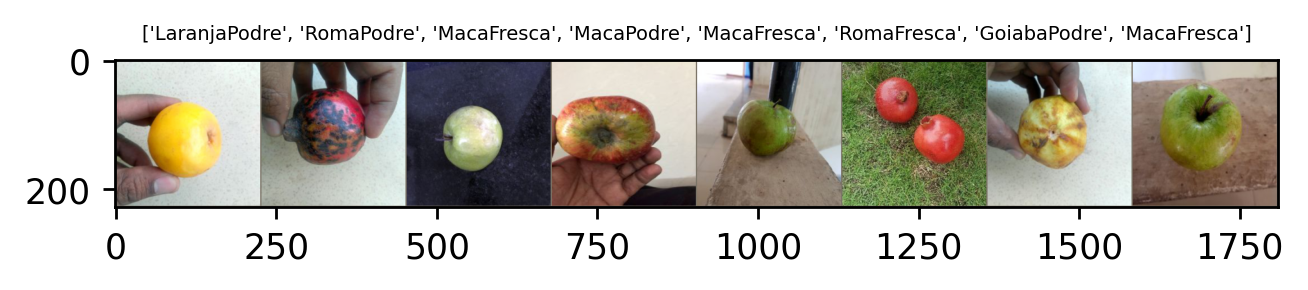

In [ ]:
# Pega um batch de imagens do treino
inputs, classes = next(iter(dataloaders['Treino']))

# Faz um grid dos batches
out = torchvision.utils.make_grid(inputs)

# Plota o batch de imagens (correspondendo a imagem e o rótulo)
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
# função de treino
def train_model(model, criterion, optimizer, num_epochs=15):
    
    # Calcula o tempo do treinamento
    since = time.time()

    # Faz uma cópia do modelo, e a medida que vai melhorando o modelo; atualiza a CNN com os pesos ajustados
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # iterar até a quantidade finita de épocas
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Cada época tem uma fase de treinamento e validação
        for phase in ['Treino', 'Teste']:
            if phase == 'Treino':
                model.train()  # Definir modelo para o modo de treinamento
            else:
                model.eval()   # Definir modelo para o modo de avaliação

            # calular o erro da época
            running_loss = 0.0

            # calcular a acurácia
            running_corrects = 0

            # Iterar sobre os dados.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zera o parâmetro do gradiente para não obter os gradientes das épocas passadas
                optimizer.zero_grad()

                # frente
                # acompanhando o histórico apenas para o treino
                with torch.set_grad_enabled(phase == 'Treino'):
                    outputs = model(inputs) # passa os dados de treino para o modelo
                    _, preds = torch.max(outputs, 1) # o resultado da predição
                    loss = criterion(outputs, labels) # o cálculo do erro

                    # retroceder + otimizar somente se estiver em fase de treinamento
                    if phase == 'Treino':
                        loss.backward() # calcula a retropropagação do erro
                        optimizer.step() # atualiza os pesos da CNN com base na retropropagação do erro

                # estatisticas
                running_loss += loss.item() * inputs.size(0) # calcula o erro das amostras
                running_corrects += torch.sum(preds == labels.data) # calcula a acurácia das amostras

            epoch_loss = running_loss / dataset_sizes[phase] # calcula o erro geral da época atual
            epoch_acc = running_corrects.double() / dataset_sizes[phase] # calcula a acurácia geral da época atual

            # Mostra a fase, o erro, e acurácia da respectiva fase (treinamento ou validação)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Verifica se a acurácia atual é melhor do que a acurácia que está salva.
            # Se for melhor, então atualiza o modelo e os pesos da CNN
            if phase == 'Teste' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    # verifica o tempo final do treinamento
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Ler o melhor modelo da fase de treinamento
    model.load_state_dict(best_model_wts)
    # retorna o melhor modelo de treino
    return model

In [ ]:
# Função para visualizar os dados de validação por batch (número de imagens = 6)
def visualize_model(model, num_images=10):

    # obtém o modelo de treinamento
    was_training = model.training

    # Faz as predições com os dados de validação
    model.eval()

    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        # iterar os dados de validação        
        for i, (inputs, labels) in enumerate(dataloaders['Teste']):
            inputs = inputs.to(device) # dados de validação
            labels = labels.to(device) # labels de validação

            # apresenta os dados de validação para o modelo
            outputs = model(inputs)
            # calcula a predição
            _, preds = torch.max(outputs, 1)

            # plotar o rótulo da classe predita e embaixo a imagem original (ants ou bees)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]),fontsize=30)
                imshow(inputs.cpu().data[j])

                # Só para finalizar o loop (até a quantidade de imagens (6))
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training) # só para dizer que está no modo de treinamento

In [ ]:
# testando as saidas da camadas conv2d
# Use esta opção para clacular corretamente as dimensões

# Insira a dimensão de entrada (111x111) e o tamanho do filtro (3x3)
# Gera como resultado o tamanho do feature map
out_conv2d(111, 3)

109.0

In [ ]:
# Criando uma rede convolucional (topologia da CNN)
class classificador(nn.Module):

  def __init__(self):
    super().__init__()

    # Criação das camadas convolucionais    
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3,3)) # saida 222x222 (no pooling cai pela metade -> 111) vai gerar 64 feature maps
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3)) # saida 109x109 (no pooling cai pela metade -> 54) vai gerar 128 feature maps

    # Criação da função relu
    self.activation = nn.ReLU()

    # Criação do pooling
    self.pool = nn.MaxPool2d(kernel_size = (2,2))

    # Criação do flatten para vetorizar a imagem ao final das camadas totalmente conectadas
    self.flatten = nn.Flatten() # 54*54 * 128 channels

    # Camadas lineares da rede neural (os neurônios totalmente conectados)
    self.linear1 = nn.Linear(in_features=128 * 54*54, out_features=128)
    self.linear2 = nn.Linear(128, 64)
    self.output = nn.Linear(64, 12) # gera para as doze classes

    # Dropout para diminuir overfitting (desativa 20% dos neurônios de uma camada oculta)
    self.dropout = nn.Dropout(p = 0.2)

  # Fluxo da passagem da imagem na rede 
  def forward(self, X):

    # X = Imagem de entrada 224x224
    # Ao passar a imagem de entrada para a primeira convolução 3x3 a saída eh 222x222   
    # Ao passar o pooling na imagem 222x222, então a imagem cai para 111x111 
    X = self.pool(self.activation(self.conv1(X)))

    # X = Feature map 111x111
    # Ao passar o feature map para a segunda convolução 3x3 a saída eh 109x109
    # Ao passar o pooling na imagem 109x109, então a imagem cai para 54x54
    X = self.pool(self.activation(self.conv2(X)))
    
    # 54x54 um único vetor de features
    X = self.flatten(X)

    # desativa 20% dos neurônios da primeira camada oculta
    X = self.dropout(self.activation(self.linear1(X)))

    # desativa 20% dos neurônios da segunda camada oculta
    X = self.dropout(self.activation(self.linear2(X)))

    # passar o dado pela camada de saída
    X = self.output(X)

    # retorna o vetor de ativação do neurônio (valor ponto flutuante, indica a intensidade de ativação do neurônio)
    return X

In [ ]:
# Criando objeto da estrutura da rede (topologia da rede)
net = classificador()
print(net)

classificador(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=373248, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=12, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [ ]:
# Definindo os parâmetros importantes do treinamento

# Função de custo e função de otimização dos parâmetros
criterion = nn.CrossEntropyLoss() # define o critério do erro (função de perda eh entropia)
optimizer = optim.SGD(net.parameters(), lr=0.01) # define a taxa de aprendizado e o otimizador SGD (Stochastic gradient descent)

In [ ]:
# Colocar a rede na GPU
net.to(device)

classificador(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=373248, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=12, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
# treinar o modelo. Apresentar os dados de treino para treinar o modelo
trained_model = train_model(net, criterion, optimizer, num_epochs=20)

Epoch 0/19
----------
Treino Loss: 1.4308 Acc: 0.5057
Teste Loss: 0.7756 Acc: 0.7347

Epoch 1/19
----------
Treino Loss: 0.7774 Acc: 0.7371
Teste Loss: 0.9393 Acc: 0.7238

Epoch 2/19
----------
Treino Loss: 0.5680 Acc: 0.8065
Teste Loss: 0.3387 Acc: 0.8873

Epoch 3/19
----------
Treino Loss: 0.4463 Acc: 0.8559
Teste Loss: 0.2982 Acc: 0.9030

Epoch 4/19
----------
Treino Loss: 0.3657 Acc: 0.8787
Teste Loss: 0.2851 Acc: 0.9084

Epoch 5/19
----------
Treino Loss: 0.2945 Acc: 0.9000
Teste Loss: 4.5210 Acc: 0.5180

Epoch 6/19
----------
Treino Loss: 0.2887 Acc: 0.9075
Teste Loss: 0.2698 Acc: 0.9208

Epoch 7/19
----------
Treino Loss: 0.2464 Acc: 0.9196
Teste Loss: 1.1428 Acc: 0.7552

Epoch 8/19
----------
Treino Loss: 0.2194 Acc: 0.9269
Teste Loss: 0.1869 Acc: 0.9456

Epoch 9/19
----------
Treino Loss: 0.1723 Acc: 0.9412
Teste Loss: 0.2010 Acc: 0.9392

Epoch 10/19
----------
Treino Loss: 0.1542 Acc: 0.9525
Teste Loss: 0.8126 Acc: 0.8296

Epoch 11/19
----------
Treino Loss: 0.1509 Acc: 0.952

In [ ]:
#Salvando o modelo:

model_scripted = torch.jit.script(trained_model) # Export to TorchScript
model_scripted.save('model_scripted.pt') # Save


In [ ]:
#Load:

trained_model = torch.jit.load('model_scripted.pt')
trained_model.eval()

ValueError: ignored

In [ ]:
# Visualizar a predição de alguns dados de teste (6 imagens)
visualize_model(trained_model)

### Redes Neurais convolucionais pré treinadas e Transfer Learning

Existem modelos pré treinados disponíveis no módulo models do pytorch.

Estas redes foram treinadas e validadas em competições e são capzaes de classificar várias coisas: 1000 classes.

Podemos usar estas redes como base para os nossos problemas e retreiná-las com os nossos dados.



In [ ]:
# Carregando o modelo pré-treinado VGG16 (CNN) do pytorch
model_ft = models.vgg16(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Mostra a topologia/estrutura da CNN VGG16
print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Acessando a quantidade de neurônios da última camada oculta (4096)
num_ftrs = model_ft.classifier[6].in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# Foi removido a camada de 1000 classes e substituído por 2 classes de saída
# E criado uma nova camada (4096, 2) para substituir a camada oculta existente
# Assim, usamos o modelo pré treinado da VGG16 para o nosso problema em questão
model_ft.classifier[6] = nn.Linear(num_ftrs, 2)

# Apresenta a rede para GPU
model_ft = model_ft.to(device)

# Define os critérios
criterion = nn.CrossEntropyLoss()

# Define o otimizador e a taxa de aprendizado
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001)

In [ ]:
# imprime a estrutura/topologia do modelo 
print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# treinar a última camada da rede CNN, e apresentar o que a rede extraiu de features do VGG16
trained_model = train_model(model_ft, criterion, optimizer_ft, num_epochs=15)

Epoch 0/14
----------


RuntimeError: ignored

In [ ]:
# Visualiza a predição de alguns dados de teste (6 imagens)
visualize_model(trained_model)